In [1318]:
import numpy as np
from scipy.sparse.linalg import LinearOperator
from scipy.integrate import quad
from scipy.linalg import solve
from typing import Callable
from matplotlib import pyplot as plt
import time
import pandas as pd

We consider a two-point boundary value problem:

$$
\left\{
\begin{aligned}
  -pu''(x) + qu(x) = f(x) \\
  u(a) = 0 \quad
  u(b) = 0
\end{aligned}
\right.
$$

In [1319]:
N: np.int64 = 10
K: np.int64 = 94

a: np.float64 = np.floor(np.pi*(N + 10))
b: np.float64 = a + K/50 + 2

p: np.float64 = K*np.exp(10*N/K)
q: np.float64 = N*np.sin(np.power(K, N)) + 2*K

print(f'Segment boundaries: {a}, {b}')
print(f'Coeffiсients:       {p}, {q}')

Segment boundaries: 62.0, 65.88
Coeffiсients:       272.35995884348756, 184.2541767404671


$\displaystyle u = -\cosh{\left(x-a-\frac{b-a}{2}\right)}+\cosh{\left(-\frac{b-a}{2} \right)} \implies \frac{du}{dx} = -\sinh{\left(x-a-\frac{b-a}{2}\right)} \implies \frac{d^2u}{dx^2} = -\cosh{\left(x-a-\frac{b-a}{2}\right)}$


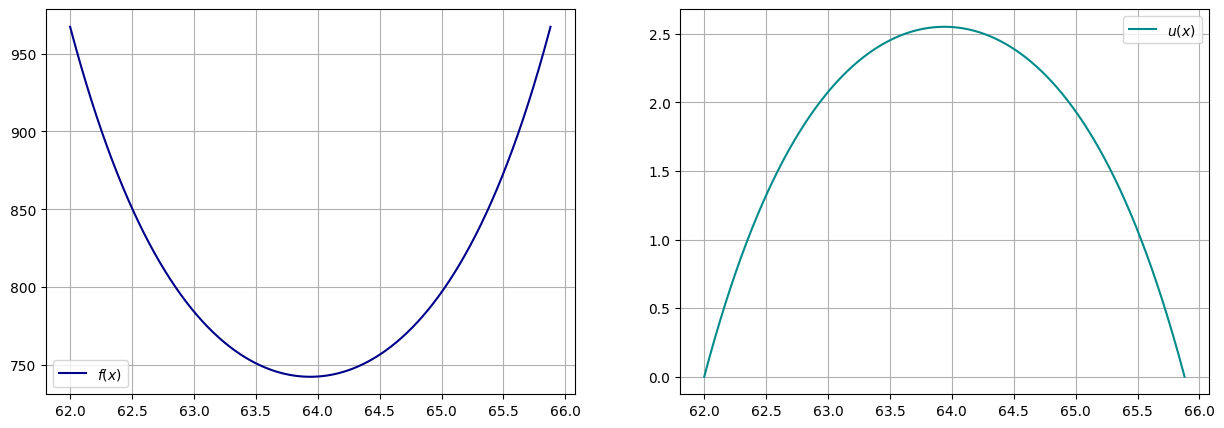

Zeros of test function
u(a) = 0.0
u(b) = 0.0


In [1320]:
aver: np.float64 = a + (b-a)/2

u:   Callable[[np.float64], np.float64] = lambda x: -np.cosh(x - aver) + np.cosh(a - aver)
du:  Callable[[np.float64], np.float64] = lambda x: -np.sinh(x - aver)
ddu: Callable[[np.float64], np.float64] = lambda x: -np.cosh(x - aver)

f = lambda x: -p*ddu(x) + q*u(x)

func = np.array([f, u], dtype=object)
name = np.array(['$f(x)$', '$u(x)$'], dtype=str)
col  = np.array(['darkblue', 'darkcyan'], dtype=str)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(a, b, 1000)

for i in range(axs.size):
    axs[i].plot(x, func[i](x), label=name[i], color=col[i])
    axs[i].legend()
    axs[i].grid()

plt.show()

print(f'Zeros of test function\nu(a) = {u(a)}\nu(b) = {u(b)}')

### 1. Construct a difference $FEM$ scheme without creating the matrix $A$. System dimension $n = 4096, 2048, 1024, 512, 256$

In [ ]:
nArr = np.array([np.power(2, i)+1 for i in range(8, 13)], dtype=np.int64)[::-1]

def vect(f: Callable[[np.float64], np.float64], n:np.float64)->np.ndarray:
    global a, b
    n += 1
    x, h = np.linspace(a, b, n+1, retstep=True)
    xf = lambda x: x*f(x)
    v = np.zeros(n-1)

    for i in range(1, n):
        v[i-1] = quad(xf, x[i-1], x[i])[0] - x[i-1]*quad(f, x[i-1], x[i])[0] + x[i+1]*quad(f, x[i], x[i+1])[0] - quad(xf, x[i], x[i+1])[0]
    
    return 1*np.power(h, -2)*v

def operator(v:np.ndarray)->np.ndarray:
    global a, b, p, q
    h = (b-a)/v.size

    res1, res2 = np.zeros_like(v), np.zeros_like(v)
    res1[:] += 2*v
    res1[1:] -= v[:-1]
    res1[:-1] -= v[1:]

    res2[:] += 4*v
    res2[1:] += v[:-1]
    res2[:-1] += v[1:]

    return p/(h**2)*res1 + q/6*res2

def buildOperator(n:np.int64)->LinearOperator:
    return LinearOperator((n, n), operator)

def buildMatrix(A:LinearOperator)->np.ndarray:
    n = A.shape[0]
    return np.column_stack([A(np.eye(n)[:, i]) for i in range(n)])

print(f'Array of dimensions: {nArr-1}')

Array of dimensions: [4096 2048 1024  512  256]


### 2. Implement the conjugate gradient method $(CG)$ in such way that it works with an operator implementing the matrix-vector product corresponding to the method and $FEM$ system.

In [1322]:
def CG(A:LinearOperator, x:np.ndarray, b:np.ndarray, iter:np.int64=0)->np.ndarray:
    
    def CG_auxiliary(A:LinearOperator, b:np.ndarray, x:np.ndarray)->tuple[np.ndarray, np.ndarray]:
        r = b - A(x)
        z = r.copy()
        w = A(z)
        rsq = np.dot(r, r)
        a = rsq/np.dot(w, z)
        x = x + a*z
        r1 = r - a*w
        beta = np.dot(r1, r1)/rsq
        z = r1 + beta*z
        r = r1

        return x, r

    if iter != 0:
        for _ in range(iter):
            x, r = CG_auxiliary(A, b, x)
    else:
        while True:
            x, r = CG_auxiliary(A, b, x)
            if np.linalg.norm(r, ord=2) < 1e-10:
                break
        
    return x

k = 5
v = np.random.uniform(1, 3, k)
print(f'Solution using operator: {CG(buildOperator(k), np.zeros(k), v)}')
print(f'Solution using matrix:   {solve(buildMatrix(buildOperator(k)), v)}')


Solution using operator: [0.00556428 0.00717801 0.00630714 0.00579174 0.00464242]
Solution using matrix:   [0.00556428 0.00717801 0.00630714 0.00579174 0.00464242]


In [1323]:
def thomasMeth(v:np.ndarray)->np.ndarray:
    n: np.int64 = v.size
    A = buildOperator(n)
    belowDiag, diag, aboveDiag = np.zeros(n-1), np.zeros(n), np.zeros(n-1)

    for i in range(n):
        ei = np.zeros(n)
        ei[i] = 1
        row = A(ei)
        diag[i] = row[i]
        if i > 0:
            belowDiag[i-1] = row[i-1]
        if i < n-1:
            aboveDiag[i] = row[i+1]

    c, d = np.zeros(n-1), np.zeros(n)
    c[0] = aboveDiag[0]*np.power(diag[0], -1)
    d[0] = v[0]*np.power(diag[0], -1)

    for i in range(1, n):
        denom = diag[i] - belowDiag[i-1]*c[i-1]
        if i < n-1:
            c[i] = aboveDiag[i]*np.power(denom, -1)
        d[i] = (v[i] - belowDiag[i-1]*d[i-1])*np.power(denom, -1)

    res = np.zeros(n)
    res[-1] = d[-1]
    for i in range(n-2, -1, -1):
        res[i] = d[i] - c[i]*res[i+1]

    return res

k = 5
v = np.random.uniform(1, 3, k)
print(f'Solution using Thomas Method: {thomasMeth(v)}')
print(f'Solution using matrix:        {solve(buildMatrix(buildOperator(k)), v)}')


Solution using Thomas Method: [0.00646038 0.0090602  0.00957197 0.00933926 0.00636252]
Solution using matrix:        [0.00646038 0.0090602  0.00957197 0.00933926 0.00636252]


### 3. Implement the $MGM$.

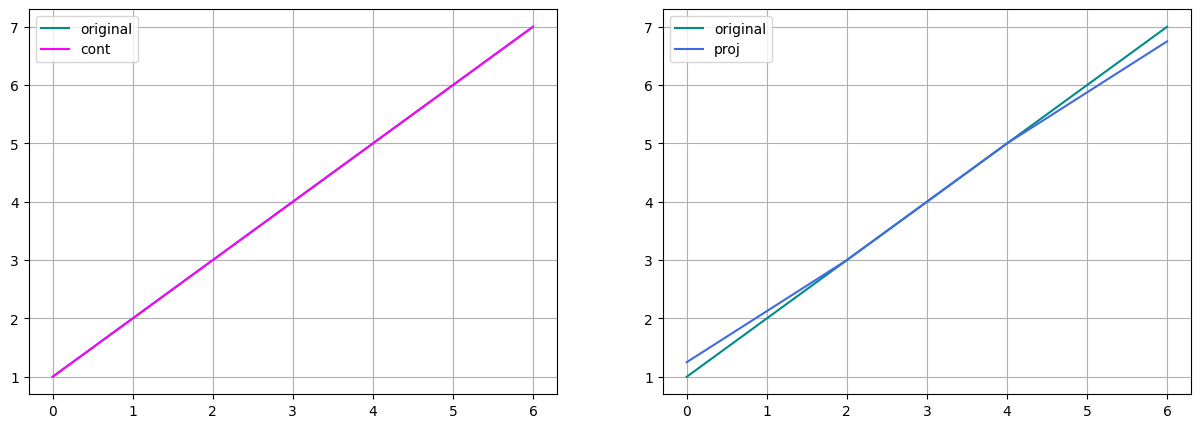

Original vector:  [1. 2. 3. 4. 5. 6. 7.]
Continued vector: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7. ]
Projected vector: [1.25 3.   5.   6.75]

Original vector:                  [1. 2. 3. 4. 5. 6. 7.]
Projection of continued vector:   [1.125 2.    3.    4.    5.    6.    6.875]
Continuation of projected vector: [1.25  2.125 3.    4.    5.    5.875 6.75 ]


In [1324]:
def cont(x:np.ndarray)->np.ndarray:
    xC = np.zeros(2*x.size - 1)
    xC[::2] = x
    xC[1::2] = 0.5*xC[:-2:2] + 0.5*xC[2::2]

    return xC

def proj(x:np.ndarray)->np.ndarray:
    n = x.size//2 + 1
    xP = np.zeros(n)
    xP[1:-1] = 0.25*x[1:-2:2] + 0.5*x[2:-1:2] + 0.25*x[3::2]
    xP[0] = 0.75*x[0] + 0.25*x[1]
    xP[-1] = 0.75*x[-1] + 0.25*x[-2]

    return xP

z = 7
x = np.linspace(1, z, z)
xC, xP = cont(x), proj(x)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(np.arange(x.size), x, label='original', color='darkcyan')
axs[0].plot(np.linspace(0, x.size-1, xC.size), xC, label='cont', color='fuchsia')

axs[1].plot(np.arange(x.size), x, label='original', color='darkcyan')
axs[1].plot(np.linspace(0, x.size-1, xP.size), xP, label='proj', color='royalblue')

for ax in axs:
    ax.legend()
    ax.grid()

plt.show()

print(f'Original vector:  {x}\nContinued vector: {xC}\nProjected vector: {xP}\n')
print(f'Original vector:                  {x}\nProjection of continued vector:   {proj(xC)}\nContinuation of projected vector: {cont(xP)}')


--------------------------------MGMW---------------------------------
Estimated time: 0.0549s
Error:          0.014759369486752928


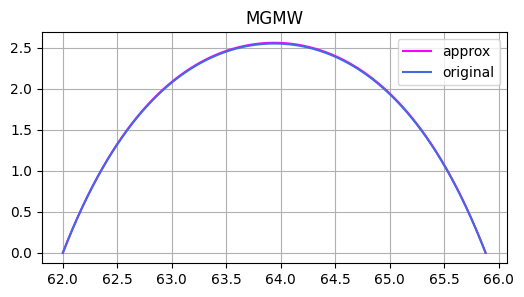

--------------------------------MGMV---------------------------------
Estimated time: 0.048s
Error:          0.014759369486316936


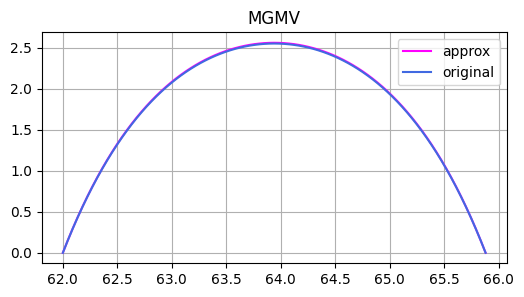

--------------------------------MGMFV---------------------------------
Estimated time: 0.06s
Error:          0.014759369486752928


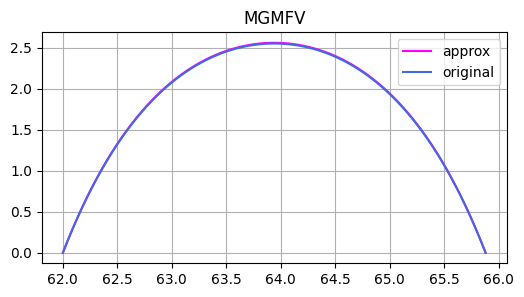

In [1325]:
def MGM_auxiliary(x:np.ndarray, b:np.ndarray, nu:np.int64)->tuple[np.ndarray, np.ndarray, np.ndarray]:
    n: np.int64 = x.size
    xNu = CG(buildOperator(n), x, b, nu)
    r = proj(b - buildOperator(n)(xNu))
    return xNu, r, np.zeros(r.size)

def MGMW(k:np.int64, x:np.ndarray, b:np.ndarray, nu:np.int64, post:str='no')->np.ndarray:
    gamma: np.int64 = 2
    if k == 0:
        return thomasMeth(b)
    else:
        if post == 'no':
            xNu, r, e = MGM_auxiliary(x, b, nu)
        else:
            xNu, r, e = MGM_auxiliary(x, b, nu//2)
        for _ in range(gamma):
            e1 = MGMV(k-1, e, r, nu)
            e = e1.copy()
        xNu += cont(e)
        if post != 'no':
            xNu = CG(buildOperator(xNu.size), xNu, b, nu//2)
        return xNu
    
def MGMV(k:np.int64, x:np.ndarray, b:np.ndarray, nu:np.int64, post:str='no')->np.ndarray:
    if k == 0:
        return thomasMeth(b)
    else:
        if post == 'no':
            xNu, r, e = MGM_auxiliary(x, b, nu)
        else:
            xNu, r, e = MGM_auxiliary(x, b, nu//2)
        e1 = MGMV(k-1, e, r, nu)
        e = e1.copy()
        xNu += cont(e)
        if post != 'no':
            xNu = CG(buildOperator(xNu.size), xNu, b, nu//2)
        return xNu

def MGMFV(k:np.int64, x:np.ndarray, b:np.ndarray, nu:np.int64, post:str='no')->np.ndarray:
    if k == 0:
        return thomasMeth(b)
    else:
        if post == 'no':
            xNu, r, e = MGM_auxiliary(x, b, nu)
        else:
            xNu, r, e = MGM_auxiliary(x, b, nu//2)
        e1 = MGMFV(k-1, e, r, nu)
        e = MGMV(k-1, e1, r, nu)
        xNu += cont(e)
        if post != 'no':
            xNu = CG(buildOperator(xNu.size), xNu, b, nu//2)
        return xNu
    
mgm = {'MGMW': MGMW, 'MGMV': MGMV, 'MGMFV': MGMFV}
    
def solver(k:np.int64, x:np.ndarray, b:np.ndarray, nu:np.int64, meth:str, post:str='no')->tuple[np.ndarray, np.float64]:
    global mgm
    alpha1 = np.zeros(x.size)
    start = time.time()
    while True:
        alpha = mgm[meth](k, alpha1, b, nu, post)
        if np.linalg.norm(alpha1 - alpha, ord=2) < 1e-10:
            break
        alpha1 = alpha.copy()
    end = time.time()
    return alpha, np.round(end-start, 4)

def drawExamp(n:np.int64, post:str='no'):
    global a, b, u, f, mgm 
    x1 = np.linspace(a, b, n+2)
    for key in mgm.keys():
        x, t = solver(2, np.zeros(n), vect(f, n), 15, key, post)
        x = np.array([0.0]+x.tolist()+[0.0])

        print(f"--------------------------------{key}---------------------------------")
        print(f'Estimated time: {t}s')
        print(f'Error:          {np.linalg.norm(np.sqrt((b-a)/n)*(x - u(x1)))}')

        
        fig, axs = plt.subplots(1, 1, figsize=(6, 3))
        axs.plot(np.linspace(a, b, n+2), x, color='fuchsia', label='approx')
        axs.plot(np.linspace(a, b, n+2), u(x1), color='royalblue', label='original')
        axs.grid()
        axs.legend()
        plt.title(f'{key}')
        plt.show()

drawExamp(nArr[-1])

In [1326]:
x, t = solver(2, np.zeros(nArr[-1]), vect(f, nArr[-1]), 15, 'MGMW', 'yes')

### 4. Fill out the time table for every $n$
![Table](tableForLab3.jpg)

In [1327]:
def fillTable(meth:str)->list:
    global nArr
    nu = np.int64(np.linspace(10, 100, 10))
    k  = np.int64(np.linspace(1, 10, 10))

    dfs = [pd.DataFrame(np.nan, index=k, columns=nu) for _ in range(nArr.size)]

    for i, df in enumerate(dfs):
        for j, k_val in enumerate(k):
            for m, nu_val in enumerate(nu):
                df.iloc[j, m] = solver(k_val, np.ones(nArr[i]), nu_val, meth)[1]

    return dfs

### $n = 256$

### $n=512$

### $n=1024$

### $n=2048$

### $n=4096$

### 5. Compare with the execution time of $CG$.

### 6. Modify the $MGM$ methods by adding post-smoothing after correction from the coarse mesh. Assuming that the number of post-smoothing iterations $\nu_{post}$ is equal to the number of pre-smoothing iterations $\nu_{pre}$ and $\nu_{post} + \nu_{pre} = \nu$, determine how this affected the convergence of the method.

--------------------------------MGMW---------------------------------
Estimated time: 0.056s
Error:          0.014759369487727806


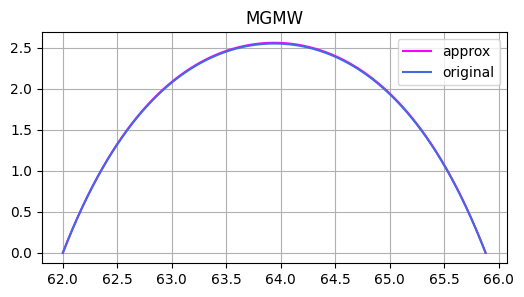

--------------------------------MGMV---------------------------------
Estimated time: 0.042s
Error:          0.014759369486042713


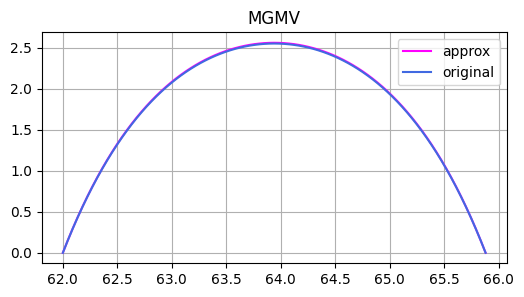

--------------------------------MGMFV---------------------------------
Estimated time: 0.0609s
Error:          0.014759369487727806


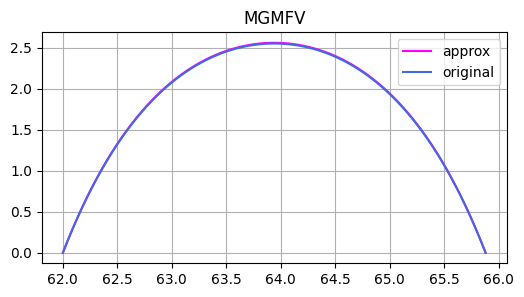

In [1328]:
drawExamp(nArr[-1], 'yes')